Using device: cuda
Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaf', 'Mosaic Disease', 'Powdery Mildew']
Class-to-Index Mapping: {'Bacterial Leaf Spot': 0, 'Downy Mildew': 1, 'Healthy Leaf': 2, 'Mosaic Disease': 3, 'Powdery Mildew': 4}
Class Distribution: Counter({0: 400, 1: 400, 2: 400, 3: 400, 4: 400})
Train Dataset Size: 1400
Validation Dataset Size: 400
Test Dataset Size: 200


model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Epoch 1/10


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Train Loss: 0.7556, Train Accuracy: 74.07%
Val Loss: 0.8243, Val Accuracy: 67.25%

Epoch 2/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Train Loss: 0.2782, Train Accuracy: 90.57%
Val Loss: 0.5521, Val Accuracy: 77.75%

Epoch 3/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Train Loss: 0.1515, Train Accuracy: 96.14%
Val Loss: 0.4647, Val Accuracy: 82.50%

Epoch 4/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


Train Loss: 0.0759, Train Accuracy: 98.93%
Val Loss: 0.4344, Val Accuracy: 82.75%

Epoch 5/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


Train Loss: 0.0433, Train Accuracy: 99.57%
Val Loss: 0.4262, Val Accuracy: 85.25%

Epoch 6/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Train Loss: 0.0269, Train Accuracy: 99.93%
Val Loss: 0.5035, Val Accuracy: 83.00%

Epoch 7/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


Train Loss: 0.0172, Train Accuracy: 100.00%
Val Loss: 0.4676, Val Accuracy: 86.75%

Epoch 8/10


Validation: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


Train Loss: 0.0129, Train Accuracy: 100.00%
Val Loss: 0.4749, Val Accuracy: 85.00%

Early stopping triggered. Stopping training.


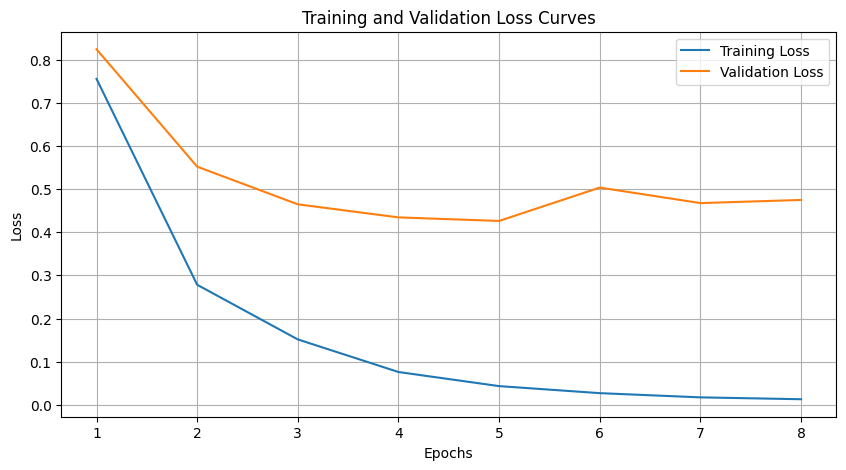

Testing: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

Test Accuracy: 85.00%


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from timm import create_model
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/pumpkin/Original/Original", transform=transform_train)

# Print dataset details
print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)

# Class distribution
labels = [sample[1] for sample in dataset.samples]
print("Class Distribution:", Counter(labels))

# Dataset split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformations
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Verify split sizes
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load EfficientViT model
model = create_model('efficientvit_b0', pretrained=True, num_classes=len(dataset.classes))
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 10
train_losses, val_losses = [], []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=3)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_correct = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_acc = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Test model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate on test set
evaluate_model(model, test_loader)


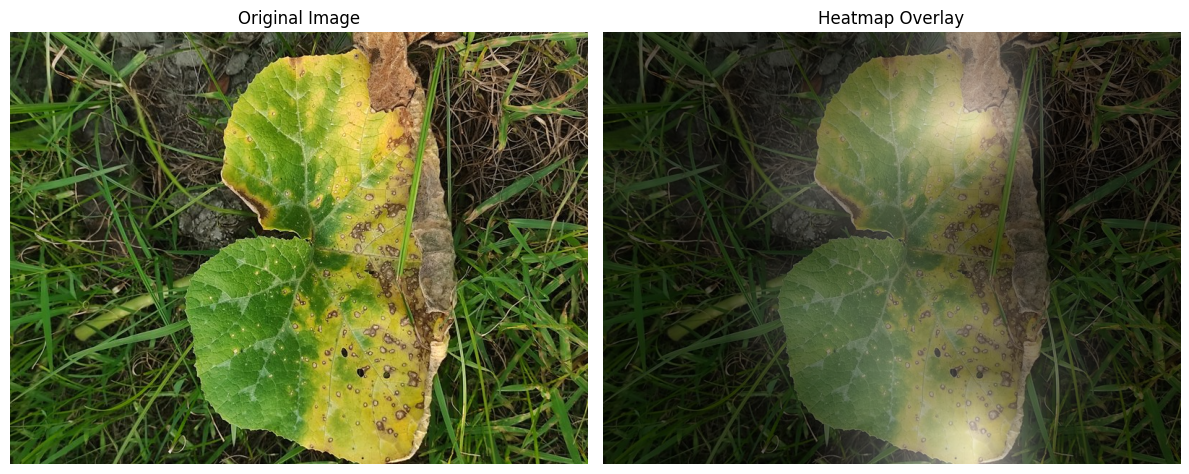

Predicted Class: 1


In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from timm import create_model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
from collections import Counter

# Replace this with the correct layer based on the inspection
target_layer = list(model.children())[-2]  # Example: Select the second-to-last layer dynamically

# Function to preprocess a single image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    return input_tensor, image

# Grad-CAM implementation
def grad_cam_efficientvit(model, input_tensor, target_layer, target_class=None):
    model.eval()

    # Forward hook for activations
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    # Backward hook for gradients
    gradients = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    if target_class is None:
        target_class = pred_class

    # Backward pass
    model.zero_grad()
    output[0, target_class].backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Process activations and gradients
    activations = activations[0].detach()
    gradients = gradients[0].detach()

    # Pool gradients across spatial dimensions
    pooled_grads = torch.mean(gradients, dim=[0, 2, 3])

    # Weight activations by gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]

    # Compute Grad-CAM heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= heatmap.max()

    return heatmap.cpu().numpy(), pred_class

# Visualize Grad-CAM heatmap
def visualize_grad_cam(image, heatmap):
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(image.size, Image.BILINEAR)
    heatmap = np.array(heatmap)
    heatmap = np.expand_dims(heatmap, axis=2)

    # Overlay heatmap
    superimposed_img = heatmap * 0.6 + np.array(image) * 0.4

    # Plot original and heatmap images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title("Original Image")

    ax[1].imshow(superimposed_img / 255)
    ax[1].axis('off')
    ax[1].set_title("Heatmap Overlay")
    plt.tight_layout()
    plt.show()

# Test Grad-CAM with a sample image
test_image_path = "/kaggle/input/pumpkin/Original/Original/Downy Mildew/Downy Mildew (102).jpg"  # Replace with a valid path
input_tensor, original_image = preprocess_image(test_image_path)

# Apply Grad-CAM
heatmap, predicted_class = grad_cam_efficientvit(model, input_tensor, target_layer)

# Visualize Grad-CAM
visualize_grad_cam(original_image, heatmap)

print(f"Predicted Class: {predicted_class}")
